In [1]:
import numpy as np
import matplotlib.pyplot as plt
import timewarp_lib.load_model as lm
import timewarp_lib.train_utils as tu
import torch
import pandas as pd
import json
import numpy as np
import matplotlib

/home/travers/miniconda3/envs/timewarpvae/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cmap = plt.get_cmap("viridis")

In [3]:

####clean_model_dirs = ["../results/overnight/20230921-093159.705744/savedmodel"] # TenDTWModel



In [4]:
import matplotlib
font = {        'size'   : 22}

matplotlib.rc('font', **font)

In [5]:
datatype = "train"
dtype=torch.float
device="cpu"
batch_size=100
training_data_timing_noise=0

dataName = "../data/trainTest2DLetterARescaled.npz"
# the datafile has information on how the data was cleaned
# the learned/applied model is on clean data
# so we need to convert back to trajectory data
loaded_data_dict = np.load(dataName)

ydata = torch.tensor(loaded_data_dict[datatype],dtype=dtype).to(device)
np_ydata = ydata.detach().cpu().numpy()
num_trajs, numts, traj_channels = ydata.shape
tdata = torch.tensor(np.linspace(0,1,numts),dtype=dtype).to(device).expand(num_trajs,numts).unsqueeze(2)

torch_train_data = torch.utils.data.TensorDataset(tdata, ydata)
training_dataloader = torch.utils.data.DataLoader(torch_train_data, batch_size=batch_size, shuffle=True)

In [6]:
ixs=(10,15)

In [7]:
def get_interps(saved_model_dir):
    pose_mean = loaded_data_dict["pose_mean"]
    pose_scaling = loaded_data_dict["pose_scaling"]

    modelApplier = lm.LoadedModel(saved_model_dir)
    modeldatafileobj = np.load(f"{saved_model_dir}/saved_model_info.npz",allow_pickle=True)
    modeldata = {key : (modeldatafileobj[key] if key != "initialization_function" else True) for key in modeldatafileobj.keys()}
    num_timesteps = 201
    num_channels = 2
    latent_dim = (int)(modeldata["latent_dim"])

    hi=modelApplier.model

    embeds,_ = hi.encoder.encode(ydata[ixs,],tdata[ixs,])
    embeds = embeds.detach().cpu().numpy()

    scaled_ts = hi.scalar_timewarper.timewarp(ydata[ixs,],tdata[ixs,]).detach().cpu().numpy()

    lambd = np.linspace(0,1,3)
    interpembeds = torch.tensor(np.array([embeds[0] * (1-l) + embeds[1] * (l) for l in lambd]))
    #canonical_ts = torch.tensor(np.array([np.array(tdata[0,] * (1-l) + tdata[1,] * (l)) for l in lambd]))
    canonical_ts = torch.tensor(np.array([np.linspace(0,1,num_timesteps).reshape(-1,1) for l in lambd]),dtype=torch.float)
    canonicaltime_trajs = hi.decoder.decode(interpembeds, canonical_ts).detach().numpy()

    lambd2 = np.linspace(0,1,11)
    full_interpembeds = torch.tensor(np.array([embeds[0] * (1-l) + embeds[1] * (l) for l in lambd2]))
    #full_canonical_ts = torch.tensor(np.array([np.array(tdata[0,] * (1-l) + tdata[1,] * (l)) for l in lambd2]))
    full_canonical_ts = torch.tensor(np.array([np.linspace(0,1,num_timesteps).reshape(-1,1) for l in lambd2]),dtype=torch.float)
    full_canonicaltime_trajs = hi.decoder.decode(full_interpembeds, full_canonical_ts).detach().numpy()

    return canonical_ts,canonicaltime_trajs,full_canonical_ts,full_canonicaltime_trajs

In [8]:
def save_traj_from_name(modelname):
    canonical_ts,canonicaltime_trajs,full_canonical_ts,full_canonicaltime_trajs = get_interps(modelname)
    print(canonicaltime_trajs[1].shape)
    combined_trajectory = np.hstack((canonical_ts[1],canonicaltime_trajs[1]))
    return combined_trajectory
traj = save_traj_from_name("../results/rescaled/20231011-003229.166126/savedmodel")
scaled_traj3d = np.hstack((traj[:,0].reshape(-1,1),
                           np.ones(len(traj)).reshape(-1,1)*0.8,
                           traj[:,1].reshape(-1,1)*0.08,
                           traj[:,2].reshape(-1,1)*0.08))
np.savetxt("test_trajectory.txt", scaled_traj3d,'%0.5f')

(201, 2)


In [9]:
#make_plot_from_name("../results/rescaled/20231020-163255.573136/savedmodel","noTW",[119,130,139])
#make_plot_from_name("../results/rescaled/20231021-232100.355514/savedmodel","conv")
#make_plot_from_name("../results/rescaled/20231022-200601.075614/savedmodel","TimewarpVAEDTW",[120,130,134])
#make_plot_from_name("../results/rescaled/20231011-003229.166126/savedmodel","timewarp",[135,138,141])

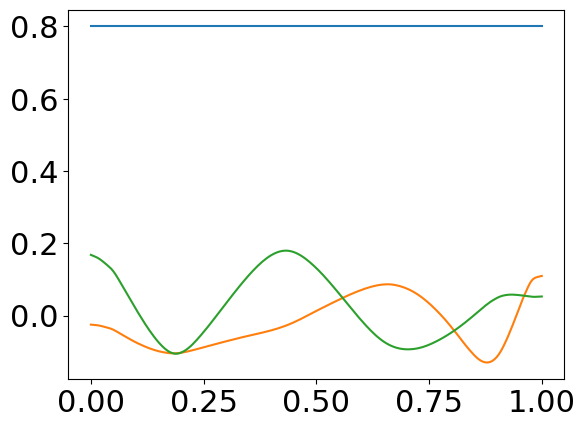

In [10]:
plt.plot(scaled_traj3d[:,0],scaled_traj3d[:,1])
plt.plot(scaled_traj3d[:,0],scaled_traj3d[:,2])
plt.plot(scaled_traj3d[:,0],scaled_traj3d[:,3])